# This file is used to analyze real experiment data collected in December of 2022


The purpose of this file to produce data for the following python and Stata code



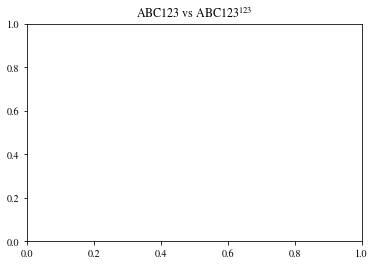

In [1]:
import pandas as pd
import numpy as np
import sys
import copy

import matplotlib.pyplot as plt
%matplotlib inline
# To change the default font like latex font
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')

import itertools
import scipy.stats as stats

In [2]:
def countCommas(s):
    try:
        return s.count(',')
    except:
        return np.nan

# Content

- [Data Import](#Data-Import)
- [Define functions and important variables](#Define-functions-and-important-variables)
- [Start Data Analysis](#Start-Data-Analysis)


# Data Import

Raw Data 

-[Return](#Content)

In [3]:
## Pilot data

# data = pd.DataFrame()
# s = { 
# #     'all_apps_wide_2022-11-04.csv': 'HETERO',
#         'all_apps_wide_2022-11-07.csv': 'HETERO' ,
#       'all_apps_wide_2022-11-07b.csv': 'HOMO' }
# for ss in s.keys() :
    
#     temp = pd.read_csv('..\\RawData\\'+ss)
#     temp['Treatment'] = s[ss]
#     data = data.append(temp,  ignore_index = True)

# data_pilot = data

In [4]:
data = pd.DataFrame()
s = { 
        '2022_12_01_reals01.csv': ['HETERO', 20], 
    '2022_12_01_reals02.csv': ['HETERO', 80], 
    '2022_12_01_reals03.csv': ['HOMO', 20], 
    '2022_12_02_reals04.csv': ['HOMO', 80], 
}
    
for ss in s.keys() :
    
    temp = pd.read_csv('..\\RawData\\'+ss)
    temp['Treatment'] = s[ss][0]
    temp['FC'] = s[ss][1]
    data = data.append(temp,  ignore_index = True)

data_ABA = data

In [5]:
data = pd.DataFrame()
s = { 
        '2022_12_06_reals05.csv': ['HETERO', 80], 
    '2022_12_06_reals06.csv': ['HETERO', 20],
    '2022_12_06_reals07.csv': ['HOMO', 80],
    '2022_12_06_reals08.csv': ['HOMO', 20],
}
    
for ss in s.keys() :
    
    temp = pd.read_csv('..\\RawData\\'+ss)
    temp['Treatment'] = s[ss][0]
    temp['FC'] = s[ss][1]
    data = data.append(temp,  ignore_index = True)

data_BAB = data

In [6]:
data_ABA.to_csv('..\\ProcessedData\\data_ABA.csv',index=False)
data_BAB.to_csv('..\\ProcessedData\\data_BAB.csv',index=False)

# Define functions and important variables 

-[Return](#Content)


In [7]:
data_BAB.columns

Index(['participant.id_in_session', 'participant.code', 'participant.label',
       'participant._is_bot', 'participant._index_in_pages',
       'participant._max_page_index', 'participant._current_app_name',
       'participant._current_page_name', 'participant.time_started_utc',
       'participant.visited',
       ...
       'PGSO_12_FeedbackQuestions.1.player.strategy5Text',
       'PGSO_12_FeedbackQuestions.1.group.id_in_subsession',
       'PGSO_12_FeedbackQuestions.1.subsession.round_number',
       'PGSO_13_Feedback.1.player.id_in_group',
       'PGSO_13_Feedback.1.player.role', 'PGSO_13_Feedback.1.player.payoff',
       'PGSO_13_Feedback.1.group.id_in_subsession',
       'PGSO_13_Feedback.1.subsession.round_number', 'Treatment', 'FC'],
      dtype='object', length=3174)

In [8]:
variables = [ 'subsession.round_number','subsession.period', 'subsession.sg', 
#              'session.code','participant.code',
             'player.id_in_group','player.endowment', 'player.join_club', 
             'player.local_community', 'player.id_in_local', 
             'player.contribution_local', 'player.contribution_global',
             'player.total_contribution_local', 'player.individual_share_local', 'player.payoff',
           'group.id_in_subsession', 'group.FC', 'group.total_contribution_global','group.individual_share_global',
             'player.button_j',# Join page
             'player.button_j_w', # Join wait
             'player.button_c', #Contribution page
             'player.button_c_w',
             'player.button_b', #Block end page
            ]


In [9]:
# Cut out data, by AppName and Length

def DataCutOutLong(data, AppName, endRound):
    col_noOpp = AppName
    col_name_a =   ['session.code', 'Treatment', 'FC','participant.code']
    data_noOppor = pd.DataFrame()
    for i in range(1,endRound+1):
        col_names = [col_noOpp+'.'+str(i)+'.'+ x for x in variables]
        col_rename = {}
        for x in variables:
            col_rename[col_noOpp+'.'+str(i)+'.'+ x ] =  x
        temp = data[col_names + col_name_a]
        temp = temp.rename(columns=col_rename) 
        data_noOppor = data_noOppor.append(temp, ignore_index=True)
    data_noOppor['endowment'] = data_noOppor['player.endowment']/10
    data_noOppor['endowment_j'] = data_noOppor['player.endowment'] * data_noOppor['player.join_club']
    data_noOppor['endowment_nj'] = data_noOppor['player.endowment'] * (1-data_noOppor['player.join_club'])
    data_noOppor['tot_contr'] = data_noOppor['player.contribution_local']+data_noOppor['player.contribution_global']
    data_noOppor['privateAcc'] = data_noOppor['player.endowment']/10 - data_noOppor['player.contribution_local']-data_noOppor['player.contribution_global'] # note: endowment has counted subjects' joining behavior 
    data_noOppor['player.payoff'] = data_noOppor['player.payoff']/10
    
   
    # Efficiency has to be measured at the larger group scale
    if 'PurePG'  in AppName and 'PGSO_09BAB_PurePG_Part4B' not in AppName:
        globalRealizedPay =data_noOppor.groupby(['session.code','subsession.round_number','group.id_in_subsession'], as_index=False)['player.payoff', 'player.endowment'].sum()
        globalRealizedPay['Efficiency'] = globalRealizedPay['player.payoff'] / (80  * 0.6 * 8)
        data_noOppor =pd.merge(data_noOppor, globalRealizedPay, on=['session.code','subsession.round_number','group.id_in_subsession'], how='inner',suffixes=('','_globalagg'))

#         localMax = data_noOppor.groupby(['session.code','subsession.round_number','player.local_community'], as_index=False)['player.endowment'].sum()
#         localMax['LocalBenefitMax'] = localMax['player.endowment'] * 4 * 0.6
        
#         localEarnedTotal = data_noOppor.groupby(['session.code','subsession.round_number','player.local_community'], as_index=False)['ActualTokenEarned'].sum()
#         data_noOppor = pd.merge(data_noOppor, localEarnedTotal, on=['session.code','subsession.round_number','player.local_community'], how='inner',suffixes=('','_localEarnedTotal'))

#         data_noOppor = pd.merge(data_noOppor, localMax, on=['session.code','subsession.round_number','player.local_community'], how='inner',suffixes=('','_localMax'))
        
#         data_noOppor['Efficiency'] = data_noOppor['player.payoff']/80/0.6
#         data_noOppor['Efficiency2'] = (data_noOppor['ActualTokenEarned_localEarnedTotal'] - data_noOppor["player.endowment_localMax"])/(data_noOppor["LocalBenefitMax"] - data_noOppor["player.endowment_localMax"])

#         data_noOppor['Efficiency2'] = 
    
    if 'ClubOpp' in AppName or 'PGSO_09BAB_PurePG_Part4B' in AppName:
        globalRealizedPay =data_noOppor.groupby(['session.code','FC', 'subsession.round_number','group.id_in_subsession'], as_index=False)['player.payoff', 'player.endowment'].sum()
#         globalRealizedPay['Efficiency'] = globalRealizedPay['player.payoff'] / (globalRealizedPay['player.endowment'] * 8 * 0.6)*10
        globalRealizedPay['Efficiency'] = globalRealizedPay['player.payoff'] / (  (160 - globalRealizedPay['FC']/10*8 )* 0.6 * 8)
        data_noOppor =pd.merge(data_noOppor, globalRealizedPay, on=['session.code','subsession.round_number','group.id_in_subsession'], how='inner',suffixes=('','_globalagg'))
        
        globalMax =data_noOppor.groupby(['session.code',
                                 'subsession.round_number',
                                 'group.id_in_subsession'], as_index=False)['player.payoff','endowment_j','endowment_nj','player.join_club'].sum()
        globalMax = globalMax.rename(columns={"endowment_j": "ClubTotal", "endowment_nj": "LocalTotal", 'player.join_club':"ClubSize"})
        globalMax['SocialBenefitMax'] = globalMax['ClubTotal'] * globalMax['ClubSize'] * 0.6 +  globalMax['LocalTotal'] * 4 * 0.6 
        globalMax.loc[globalMax['ClubSize']<4,'SocialBenefitMax'] = globalMax['ClubTotal'] * 4 * 0.6 +  globalMax['LocalTotal'] * 4 * 0.6 
        globalMax['Efficiency2'] = globalMax['player.payoff'] / globalMax['SocialBenefitMax'] *10
        
        data_noOppor =pd.merge(data_noOppor, globalMax, on=['session.code','subsession.round_number','group.id_in_subsession'], how='inner',suffixes=('','_globalMax'))
        
        
#         localMax = data_noOppor.groupby(['session.code','subsession.round_number','player.local_community'], as_index=False)['player.endowment'].sum()
#         localMax['LocalBenefitMax'] = localMax['player.endowment'] * 4 * 0.6

#         data_noOppor = pd.merge(data_noOppor, localMax, on=['session.code','subsession.round_number','player.local_community'], how='inner',suffixes=('','_localMax'))


#         globalMax =data_noOppor.groupby(['session.code','subsession.round_number','group.id_in_subsession'], as_index=False)['endowment_j','player.join_club'].sum()
#         globalMax['GlobalBenefitMax'] = globalMax['endowment_j'] * globalMax['player.join_club'] * 0.6

#         data_noOppor =pd.merge(data_noOppor, globalMax, on=['session.code','subsession.round_number','group.id_in_subsession'], how='inner',suffixes=('','_globalMax'))

#         data_noOppor['ActualTokenEarned'] =data_noOppor['player.payoff'] * 10
#         # data_noOppor['privateAcc'] * 10  + 0.6* data_noOppor['group.total_contribution_global'] + 0.6* data_noOppor['player.total_contribution_local'] Wrong, not considered the join behavior
#         localEarnedTotal = data_noOppor.groupby(['session.code','subsession.round_number','player.local_community'], as_index=False)['ActualTokenEarned'].sum()
#         data_noOppor = pd.merge(data_noOppor, localEarnedTotal, on=['session.code','subsession.round_number','player.local_community'], how='inner',suffixes=('','_localEarnedTotal'))

#         data_noOppor["MaxBenefit"] = data_noOppor[["LocalBenefitMax", "GlobalBenefitMax"]].max(axis=1)

#         data_noOppor['Efficiency'] = data_noOppor['player.payoff']/data_noOppor["MaxBenefit"]

#         data_noOppor['Efficiency2'] = (data_noOppor['ActualTokenEarned_localEarnedTotal'] - data_noOppor["player.endowment_localMax"])/(data_noOppor["MaxBenefit"] - data_noOppor["player.endowment_localMax"])
    
    
    return data_noOppor

In [10]:
AppName = 'PGSO_05BAB_ClubOpp_Par2BBB'
endRound = 10


col_noOpp = AppName
col_name_a =   ['session.code', 'Treatment', 'FC','participant.code']
data_noOppor = pd.DataFrame()
for i in range(1,endRound+1):
    col_names = [col_noOpp+'.'+str(i)+'.'+ x for x in variables]
    col_rename = {}
    for x in variables:
        col_rename[col_noOpp+'.'+str(i)+'.'+ x ] =  x
    temp = data[col_names + col_name_a]
    temp = temp.rename(columns=col_rename) 
    data_noOppor = data_noOppor.append(temp, ignore_index=True)
data_noOppor['endowment'] = data_noOppor['player.endowment']/10
data_noOppor['endowment_j'] = data_noOppor['player.endowment'] * data_noOppor['player.join_club']
data_noOppor['endowment_nj'] = data_noOppor['player.endowment'] * (1-data_noOppor['player.join_club'])
data_noOppor['tot_contr'] = data_noOppor['player.contribution_local']+data_noOppor['player.contribution_global']
data_noOppor['privateAcc'] = data_noOppor['player.endowment']/10 - data_noOppor['player.contribution_local']-data_noOppor['player.contribution_global'] # note: endowment has counted subjects' joining behavior 
data_noOppor['player.payoff'] = data_noOppor['player.payoff']/10

In [11]:
globalMax =data_noOppor.groupby(['session.code',
                                 'subsession.round_number',
                                 'group.id_in_subsession'], as_index=False)['player.payoff', 'endowment_j','endowment_nj','player.join_club'].sum()
globalMax = globalMax.rename(columns={"endowment_j": "ClubTotal", "endowment_nj": "LocalTotal", 'player.join_club':"ClubSize"})
globalMax['SocialBenefitMax'] = globalMax['ClubTotal'] * globalMax['ClubSize'] * 0.6 +  globalMax['LocalTotal'] * 4 * 0.6 
globalMax.loc[globalMax['ClubSize']<4,'SocialBenefitMax'] = globalMax['ClubTotal'] * 4 * 0.6 +  globalMax['LocalTotal'] * 4 * 0.6 
globalMax['Efficiency2'] = globalMax['player.payoff'] / globalMax['SocialBenefitMax'] *10

# data_noOppor =pd.merge(data_noOppor, globalMax, on=['session.code','subsession.round_number','group.id_in_subsession'], how='inner',suffixes=('','_globalMax'))

globalMax['Efficiency2'].describe()

C:\Users\xinxi\AppData\Local\Temp/ipykernel_10580/2498677884.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  globalMax =data_noOppor.groupby(['session.code',


count    80.000000
mean      0.606464
std       0.097942
min       0.382056
25%       0.553183
50%       0.591399
75%       0.645880
max       0.874074
Name: Efficiency2, dtype: float64

In [12]:
localMax = data_noOppor.groupby(['session.code','subsession.round_number','player.local_community'], as_index=False)['player.endowment'].sum()
localMax['LocalBenefitMax'] = localMax['player.endowment'] * 4 * 0.6

data_noOppor = pd.merge(data_noOppor, localMax, on=['session.code','subsession.round_number','player.local_community'], how='inner',suffixes=('','_localMax'))


globalMax =data_noOppor.groupby(['session.code','subsession.round_number','group.id_in_subsession'], as_index=False)['endowment_j','player.join_club'].sum()
globalMax['GlobalBenefitMax'] = globalMax['endowment_j'] * globalMax['player.join_club'] * 0.6

data_noOppor =pd.merge(data_noOppor, globalMax, on=['session.code','subsession.round_number','group.id_in_subsession'], how='inner',suffixes=('','_globalMax'))

data_noOppor['ActualTokenEarned'] =data_noOppor['player.payoff'] * 10
# data_noOppor['privateAcc'] * 10  + 0.6* data_noOppor['group.total_contribution_global'] + 0.6* data_noOppor['player.total_contribution_local'] Wrong, not considered the join behavior
localEarnedTotal = data_noOppor.groupby(['session.code','subsession.round_number','player.local_community'], as_index=False)['ActualTokenEarned'].sum()
data_noOppor = pd.merge(data_noOppor, localEarnedTotal, on=['session.code','subsession.round_number','player.local_community'], how='inner',suffixes=('','_localEarnedTotal'))

data_noOppor["MaxBenefit"] = data_noOppor[["LocalBenefitMax", "GlobalBenefitMax"]].max(axis=1)

data_noOppor['Efficiency'] = data_noOppor['player.payoff']/data_noOppor["MaxBenefit"]

data_noOppor['Efficiency2'] = (data_noOppor['ActualTokenEarned_localEarnedTotal'] - data_noOppor["player.endowment_localMax"])/(data_noOppor["MaxBenefit"] - data_noOppor["player.endowment_localMax"])

C:\Users\xinxi\AppData\Local\Temp/ipykernel_10580/971385742.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  globalMax =data_noOppor.groupby(['session.code','subsession.round_number','group.id_in_subsession'], as_index=False)['endowment_j','player.join_club'].sum()


In [14]:
data_noOppor.columns

Index(['subsession.round_number', 'subsession.period', 'subsession.sg',
       'player.id_in_group', 'player.endowment', 'player.join_club',
       'player.local_community', 'player.id_in_local',
       'player.contribution_local', 'player.contribution_global',
       'player.total_contribution_local', 'player.individual_share_local',
       'player.payoff', 'group.id_in_subsession', 'group.FC',
       'group.total_contribution_global', 'group.individual_share_global',
       'player.button_j', 'player.button_j_w', 'player.button_c',
       'player.button_c_w', 'player.button_b', 'session.code', 'Treatment',
       'FC', 'participant.code', 'endowment', 'endowment_j', 'endowment_nj',
       'tot_contr', 'privateAcc', 'player.endowment_localMax',
       'LocalBenefitMax', 'endowment_j_globalMax',
       'player.join_club_globalMax', 'GlobalBenefitMax', 'ActualTokenEarned',
       'ActualTokenEarned_localEarnedTotal', 'MaxBenefit', 'Efficiency',
       'Efficiency2'],
      dtype='object

In [28]:
data_noOppor['player.button_j_w'].unique()

array([nan,
       ',ShowPrevious_local_total,ShowPrevious_global_total,ShowPrevious_global_rest,ShowPrevious_global_min,ShowPrevious_global_max,ShowPrevious_local_max,ShowPrevious_local_min',
       ',ShowPrevious_local_total,ShowPrevious_global_total,ShowPrevious_global_min,ShowPrevious_global_max,ShowPrevious_global_rest,ShowAllHistory_global,ShowAllHistory_local,ShowPrevious_local_rest',
       ',ShowPrevious_local_total,ShowAllHistory_local,ShowAllHistory_local,ShowPrevious_local_min,ShowPrevious_local_max,ShowPrevious_local_rest,ShowPrevious_global_total,ShowPrevious_local_min,ShowPrevious_local_min,ShowPrevious_local_min,ShowPrevious_global_min,ShowPrevious_global_rest,ShowPrevious_global_max',
       ',ShowPrevious_global_total,ShowPrevious_local_total,ShowAllHistory_global,ShowAllHistory_global,ShowAllHistory_local,ShowPrevious_global_max,ShowPrevious_global_min,ShowPrevious_global_rest,ShowPrevious_local_min',
       ',ShowPrevious_local_total,ShowPrevious_global_total,ShowPr

In [24]:
# data_noOppor['player.button_b'].unique()
for page in ['j','j_w','c','c_w','b']:
    data_noOppor['local_total_'+page]= 1*data_noOppor['player.button_'+page].str.contains('ShowPrevious_local_total', regex=False)
    data_noOppor['global_total_'+page]= 1*data_noOppor['player.button_'+page].str.contains('ShowPrevious_global_total', regex=False)
    data_noOppor['button_'+page] = data_noOppor['player.button_'+page].str.count(',')

In [25]:
data_noOppor['local_total_j'].unique()

array([nan, 1, 0], dtype=object)

In [ ]:
def ButtonChecks():
    

In [13]:

data_noOppor['Efficiency2'].describe()
# data_noOppor[data_noOppor['Efficiency2']<0]
# [['player.payoff', 'ActualTokenEarned']]
# data_noOppor[data_noOppor['player.payoff']*10!= data_noOppor['ActualTokenEarned']]

count    640.000000
mean       0.274540
std        0.177666
min        0.025000
25%        0.169112
50%        0.217700
75%        0.324140
max        0.895833
Name: Efficiency2, dtype: float64

In [188]:
data_noOppor.columns

Index(['subsession.round_number', 'subsession.period', 'subsession.sg',
       'player.id_in_group', 'player.endowment', 'player.join_club',
       'player.local_community', 'player.id_in_local',
       'player.contribution_local', 'player.contribution_global',
       'player.total_contribution_local', 'player.individual_share_local',
       'player.payoff', 'group.id_in_subsession', 'group.FC',
       'group.total_contribution_global', 'group.individual_share_global',
       'session.code', 'Treatment', 'FC', 'participant.code', 'endowment',
       'endowment_j', 'tot_contr', 'privateAcc', 'player.endowment_localMax',
       'LocalBenefitMax', 'endowment_j_globalMax',
       'player.join_club_globalMax', 'GlobalBenefitMax', 'ActualTokenEarned',
       'ActualTokenEarned_localEarnedTotal', 'MaxBenefit', 'Efficiency',
       'Efficiency2'],
      dtype='object')

In [210]:
B1 = DataCutOutLong(data_ABA, 'PGSO_08ABA_ClubOpp_Par3BBB',50)
B1['Efficiency2'].describe()
# B1[B1['Efficiency2']<0]

C:\Users\xinxi\AppData\Local\Temp/ipykernel_15292/2463659246.py:25: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  globalRealizedPay =data_noOppor.groupby(['session.code','FC', 'subsession.round_number','group.id_in_subsession'], as_index=False)['player.payoff', 'player.endowment'].sum()
C:\Users\xinxi\AppData\Local\Temp/ipykernel_15292/2463659246.py:30: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  globalMax =data_noOppor.groupby(['session.code',


count    3200.000000
mean        0.560127
std         0.130322
min         0.313929
25%         0.462095
50%         0.544271
75%         0.646354
max         0.895544
Name: Efficiency2, dtype: float64

In [209]:
A1 = DataCutOutLong(data_ABA, 'PGSO_05ABA_PurePG_Part2A',10)
A1['Efficiency'].describe()
# x = A1[A1['Efficiency']>1]
# x[['subsession.round_number', 'player.endowment','player.payoff','tot_contr','player.total_contribution_local', 'Efficiency']]
# A1[A1['Efficiency']>.4]

C:\Users\xinxi\AppData\Local\Temp/ipykernel_15292/2463659246.py:64: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  globalRealizedPay =data_noOppor.groupby(['session.code','subsession.round_number','group.id_in_subsession'], as_index=False)['player.payoff', 'player.endowment'].sum()


count    640.000000
mean       0.621426
std        0.072345
min        0.504167
25%        0.558854
50%        0.624479
75%        0.666406
max        0.835938
Name: Efficiency, dtype: float64

# Local Only vs With Opportunity


Sequence : [7, 6, 18, 17, 13, 8, 12, 7]

A1 = [7] (10 rounds)

B1 = [6,18,17]

A2 = [13]

B2 = [8]

-[Return](#Content)


In [216]:
for x in data_noOppor_A2.columns:
    print(x)

subsession.round_number
subsession.period
subsession.sg
player.id_in_group
player.endowment
player.join_club
player.local_community
player.id_in_local
player.contribution_local
player.contribution_global
player.total_contribution_local
player.individual_share_local
player.payoff
group.id_in_subsession
group.FC
group.total_contribution_global
group.individual_share_global
session.code
Treatment
FC
participant.code
endowment
endowment_j
endowment_nj
tot_contr
privateAcc
player.payoff_globalagg
player.endowment_globalagg
Efficiency
Sequence


In [219]:
A1 = DataCutOutLong(data_ABA, 'PGSO_05ABA_PurePG_Part2A',10)
A1['Sequence'] = 'A1'
A2 = DataCutOutLong(data_ABA, 'PGSO_09ABA_PurePG_Part4A',20)
A2['Sequence'] = 'A2'
B1 = DataCutOutLong(data_ABA, 'PGSO_08ABA_ClubOpp_Par3BBB',50)
B1['Sequence'] = 'B1'

B1_bab = DataCutOutLong(data_BAB, 'PGSO_05BAB_ClubOpp_Par2BBB',50)
B1_bab['Sequence'] = 'B1_bab'
A2_bab = DataCutOutLong(data_BAB, 'PGSO_08BAB_PurePG_Part3A',20)
A2_bab['Sequence'] = 'A2_bab'
B2_bab = DataCutOutLong(data_BAB, 'PGSO_09BAB_PurePG_Part4B',10)
B2_bab['Sequence'] = 'B2_bab'


# Data with opportunity 
data_Oppor_B1 = pd.concat([B1, B1_bab], ignore_index=True)
data_Oppor_allB = pd.concat([B1, B1_bab,B2_bab], ignore_index=True)



data_Oppor_B1.to_csv('..\\ProcessedData\\data_Oppor_B1.csv',index=False)
data_Oppor_allB.to_csv('..\\ProcessedData\\data_Oppor_allB.csv',index=False)

# Data local only 
data_noOppor_AllA = pd.concat([A1, A2, A2_bab], ignore_index=True)
data_noOppor_A2 = pd.concat([A2, A2_bab], ignore_index=True)


data_noOppor_AllA.to_csv('..\\ProcessedData\\data_noOppor_AllA.csv',index=False)
data_noOppor_A2.to_csv('..\\ProcessedData\\data_noOppor_A2.csv',index=False)

C:\Users\xinxi\AppData\Local\Temp/ipykernel_15292/860489259.py:25: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  globalRealizedPay =data_noOppor.groupby(['session.code','subsession.round_number','group.id_in_subsession'], as_index=False)['player.payoff', 'player.endowment'].sum()
C:\Users\xinxi\AppData\Local\Temp/ipykernel_15292/860489259.py:43: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  globalRealizedPay =data_noOppor.groupby(['session.code','FC', 'subsession.round_number','group.id_in_subsession'], as_index=False)['player.payoff', 'player.endowment'].sum()
C:\Users\xinxi\AppData\Local\Temp/ipykernel_15292/860489259.py:48: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  globalMax =data_noOppor.groupby(['session.code',


In [220]:
B2_bab

,subsession.round_number,subsession.period,subsession.sg,player.id_in_group,player.endowment,player.join_club,player.local_community,player.id_in_local,player.contribution_local,player.contribution_global,...,player.payoff_globalagg,player.endowment_globalagg,Efficiency,player.payoff_globalMax,ClubTotal,LocalTotal,ClubSize,SocialBenefitMax,Efficiency2,Sequence
0,1,1,1,1,300,0,1,0,0,0,...,147.6,1280,0.320312,147.6,280,1000,4,3072.0,0.480469,B2_bab
1,1,1,1,5,300,0,2,0,0,0,...,147.6,1280,0.320312,147.6,280,1000,4,3072.0,0.480469,B2_bab
2,1,1,1,2,300,0,1,1,5,0,...,147.6,1280,0.320312,147.6,280,1000,4,3072.0,0.480469,B2_bab
3,1,1,1,6,220,1,2,1,0,6,...,147.6,1280,0.320312,147.6,280,1000,4,3072.0,0.480469,B2_bab
4,1,1,1,3,20,1,1,2,0,2,...,147.6,1280,0.320312,147.6,280,1000,4,3072.0,0.480469,B2_bab
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,10,10,1,6,180,1,0,1,0,0,...,346.6,1440,0.501447,346.6,1440,0,8,6912.0,0.501447,B2_bab
636,10,10,1,3,180,1,3,2,0,0,...,346.6,1440,0.501447,346.6,1440,0,8,6912.0,0.501447,B2_bab
637,10,10,1,7,180,1,0,2,0,3,...,346.6,1440,0.501447,346.6,1440,0,8,6912.0,0.501447,B2_bab
638,10,10,1,4,180,1,3,3,2,9,...,346.6,1440,0.501447,346.6,1440,0,8,6912.0,0.501447,B2_bab


# Individual Characteristics

In [17]:
LabelDict = { 'session': 'session.code', 
            'participant': 'participant.code',
              'social_y_r' : 'PGSO_02_SocialPreferenceElicitation.1.player.responses1',
              'social_x_r' : 'PGSO_02_SocialPreferenceElicitation.1.player.responses2',
             'age' : 'PGSO_11_Demographics.1.player.ageSelect',
             'gender' : 'PGSO_11_Demographics.1.player.genderSelect',
             'major' : 'PGSO_11_Demographics.1.player.majorSelect',
             'high_school' : 'PGSO_11_Demographics.1.player.hsSelect',
              # post-survey:
              'understand' : 'PGSO_12_FeedbackQuestions.1.player.understandingSelect', 
              #choices=['Clear', 'Somewhat Clear', 'Somewhat Confusing', 'Confusing']
              'explain_better' : 'PGSO_12_FeedbackQuestions.1.player.explainedText',
              #'What could have been explained better?'
               #What was your strategy in part 2? How did you make contributions to your group account? (Please be specific)
              'contr_local' : 'PGSO_12_FeedbackQuestions.1.player.strategy1Text',
              #What was your strategy in part 3? How did you decide to pay the fee and contribute to group accounts? (Please be specific)
              'stra_global' : 'PGSO_12_FeedbackQuestions.1.player.strategy2Text',
              # 'Did you contribute to your Group Account differently when there is an opportunity to access to Group Account #2?'
              'contr_diff_club' : 'PGSO_12_FeedbackQuestions.1.player.strategy3Text',
              # 'Will your strategy be different if the fee is higher or lower?'
              'stra_diff_fee_higher_lower' : 'PGSO_12_FeedbackQuestions.1.player.strategy4Text',
              # 'Did your decision in a round depend on what happened in the previous rounds?'
              'str_dep_previous_R' : 'PGSO_12_FeedbackQuestions.1.player.strategy5Text',
             'TotalPayoff' : 'PGSO_10_PayoffScreen.1.player.TotalPayoff',
            }
# IQList = { 'IQ'+str(q) : 'DynamicPower_02d_IQ.'+str(q)+'.player.iqResponses' for q in range(1,12)}
# LabelDict.update(IQList)

In [18]:
All_data = data_ABA.append(data_BAB)
individual_data = pd.DataFrame()
for j, var in enumerate(LabelDict.keys()):
    individual_data[var] = All_data[LabelDict[var]]
# Process preference data
for var in ['social_x_r', 'social_y_r']:
    individual_data[var[:-2]] = individual_data[var].str.count('A')
individual_data.to_csv('..\\ProcessedData\\individual_data.csv',index=False)